Exercice 1 : Séries temporelles L’objectif de cet exercice est de prédire les  cotations  d’une action en  utilisant  des  réseaux
récurrents.

1.  Télécharger un dataset contenant l’historique des cotations  d’une action de votre
choix (votre entreprise en alternance, facebook, google, CAC40, etc.). Vous trouverez
ce qu’il faut ici : https://www.nasdaq.com. Il est conseillé de prendre la plus grande
période possible pour avoir le dataset le plus grand possible.

2. Charger  le  fichier  CSV  en  python  et  explorer  le  dataset.  Proposer  une  ou  plusieurs
représentations graphiques permettant de visualiser les données.

In [5]:
%pip install mplcursors -q

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras import layers as L

# Load data
NASDAQ100 = pd.read_csv("HistoricalData.csv")

# Convert the Date column
NASDAQ100["Date"] = pd.to_datetime(NASDAQ100["Date"])
NASDAQ100 = NASDAQ100.sort_values("Date").reset_index(drop=True)
NASDAQ100["Close/Last"] = pd.to_numeric(NASDAQ100["Close/Last"])

# Plot interactive line chart
fig = px.line(
    NASDAQ100,
    x="Date",
    y="Close/Last",
    title="NASDAQ 100 Historical Prices",
    labels={
        "Date": "Date",
        "Close/Last": "Close/Last"
    },
    hover_data={"Date": "|%Y-%m-%d", "Close/Last": ":.2f"}
)

# Optional: style improvements
fig.update_traces(line=dict(width=2, color="#1f77b4"), name="NASDAQ-100")
fig.update_layout(
    hovermode="x unified",
    template="plotly_white",
    legend_title_text=""
)

# Show interactive figure
fig.show()

3. Sélectionner  la  ou  les  colonnes  permettant  la  prédiction  les  cotations  de l’action
sélectionnée.

In [7]:
NASDAQ100 = NASDAQ100[["Date", "Close/Last"]]

print(NASDAQ100.head())

        Date  Close/Last
0 2015-11-09     4655.52
1 2015-11-10     4641.73
2 2015-11-11     4636.94
3 2015-11-12     4588.93
4 2015-11-13     4502.14


4. Préparer un dataset d’entrainement et de test pour l’apprentissage. En particulier, le
dataset doit être constitué de séquences de valeurs (en entrée) permettant de prédire
la (ou les) valeur(s) suivante(s) de cette séquence (target).

In [8]:
def prepare_data(data, window=60):
    X = []
    y = []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X).reshape(-1, window, 1), np.array(y)

scaler = MinMaxScaler()
NASDAQ100["Close/Last"] = scaler.fit_transform(NASDAQ100["Close/Last"].values.reshape(-1, 1))

X, y = prepare_data(NASDAQ100["Close/Last"])

n_test = int(len(X)*.2)
X_train_NASDAQ, X_test_NASDAQ = X[:-n_test], X[-n_test:]
y_train_NASDAQ, y_test_NASDAQ = y[:-n_test], y[-n_test:]

print("Train:", X_train_NASDAQ.shape, y_train_NASDAQ.shape)
print("Test:", X_test_NASDAQ.shape, y_test_NASDAQ.shape)

input_shape = (X_train_NASDAQ.shape[1], X_train_NASDAQ.shape[2])
print("Input shape:", input_shape)

EPOCHS = 20
BATCH_SIZE = 32

Train: (1965, 60, 1) (1965,)
Test: (491, 60, 1) (491,)
Input shape: (60, 1)


5.  Proposer et comparer quelques architectures neuronales à partir de couches LSTM et
GRU.  Sélectionner celle permettant d’obtenir les meilleurs résultats. Dans cette
question, la prédiction doit être faite à très court terme. Vous pouvez aussi utiliser des
couches convolutionnel 1D pour évaluer l’impact de la mémoire long terme.

In [9]:
def build_lstm_model(units=50):
    model = keras.Sequential([
        L.Input(shape=input_shape),
        L.LSTM(units, return_sequences=False),
        L.Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    return model

def build_stacked_lstm_model(units=50):
    model = keras.Sequential([
        L.Input(shape=input_shape),
        L.LSTM(units, return_sequences=True),
        L.LSTM(units),
        L.Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    return model

def build_gru_model(units=50):
    model = keras.Sequential([
        L.Input(shape=input_shape),
        L.GRU(units, return_sequences=False),
        L.Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    return model

def build_conv1d_lstm_model(filters=32, units=50):
    model = keras.Sequential([
        L.Input(shape=input_shape),
        L.Conv1D(filters=filters, kernel_size=3, activation="relu", padding="causal"),
        L.MaxPooling1D(pool_size=2),
        L.LSTM(units),
        L.Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    return model


In [10]:
models = {
    "LSTM": build_lstm_model(),
    "Stacked LSTM": build_stacked_lstm_model(),
    "GRU": build_gru_model(),
    "Conv1D + LSTM": build_conv1d_lstm_model(),
}

histories = {}
results = {}

for name, model in models.items():
    print(f"\n===== Training {name} =====")
    history = model.fit(
        X_train_NASDAQ,
        y_train_NASDAQ,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0
    )
    histories[name] = history

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test_NASDAQ, y_test_NASDAQ, verbose=0)
    results[name] = {"test_mse": test_loss, "test_mae": test_mae}
    print(f"{name} - Test MSE: {test_loss:.6f}, Test MAE: {test_mae:.6f}")



===== Training LSTM =====
LSTM - Test MSE: 0.001315, Test MAE: 0.031764

===== Training Stacked LSTM =====
Stacked LSTM - Test MSE: 0.000671, Test MAE: 0.020959

===== Training GRU =====
GRU - Test MSE: 0.000166, Test MAE: 0.009866

===== Training Conv1D + LSTM =====
Conv1D + LSTM - Test MSE: 0.002278, Test MAE: 0.043256


In [11]:
results_df = pd.DataFrame(results).T
print("\n===== Comparison of models on test set (scaled values) =====")
print(results_df)


===== Comparison of models on test set (scaled values) =====
               test_mse  test_mae
LSTM           0.001315  0.031764
Stacked LSTM   0.000671  0.020959
GRU            0.000166  0.009866
Conv1D + LSTM  0.002278  0.043256


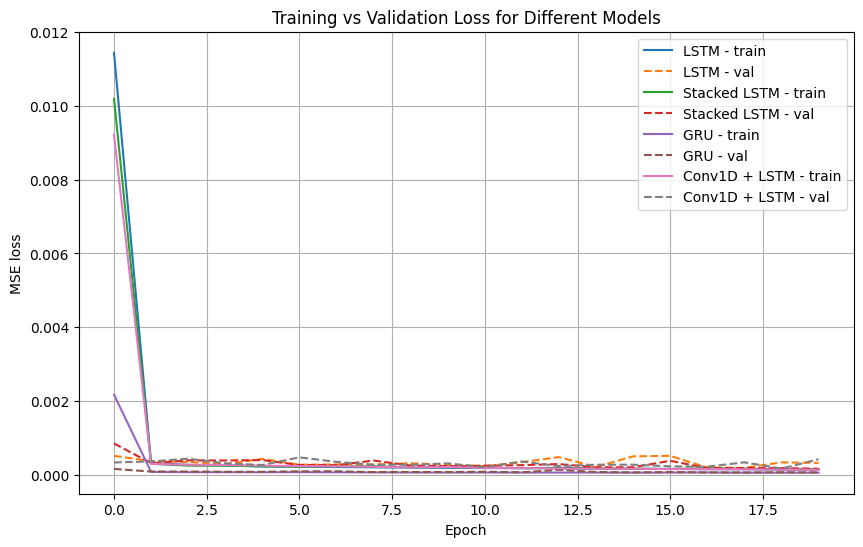

In [12]:
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history["loss"], label=f"{name} - train")
    plt.plot(history.history["val_loss"], linestyle="--", label=f"{name} - val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Validation Loss for Different Models")
plt.legend()
plt.grid(True)
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


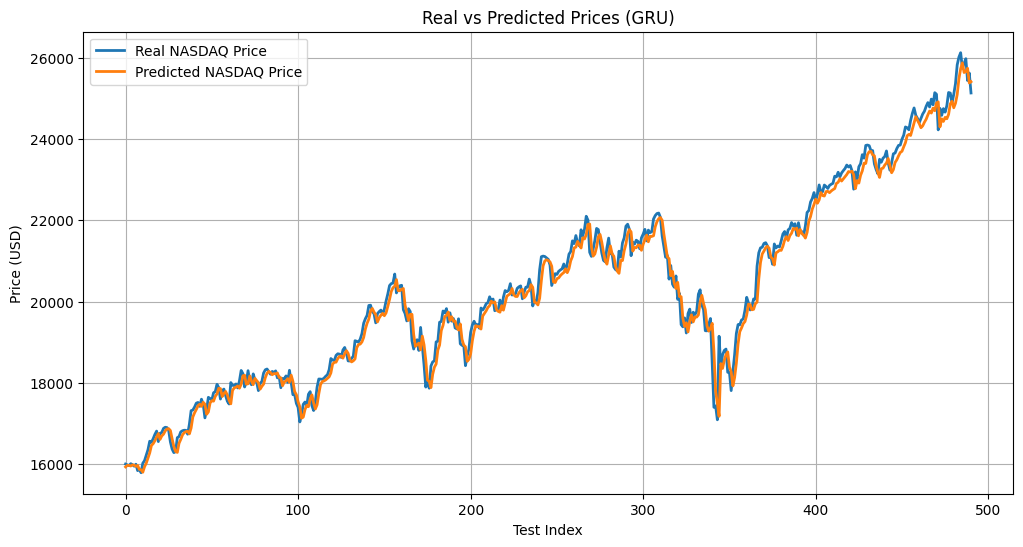

In [13]:
# Predict using best model
best_model_name = min(results, key=lambda k: results[k]["test_mse"])
best_model = models[best_model_name]
y_pred_test = best_model.predict(X_test_NASDAQ)

# Reshape for inverse_transform
y_test_NASDAQ_reshaped = y_test_NASDAQ.reshape(-1, 1)

# Inverse transform to original scale
y_test_real = scaler.inverse_transform(y_test_NASDAQ_reshaped)
y_pred_real = scaler.inverse_transform(y_pred_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label="Real NASDAQ Price", linewidth=2)
plt.plot(y_pred_real, label="Predicted NASDAQ Price", linewidth=2)
plt.title(f"Real vs Predicted Prices ({best_model_name})")
plt.xlabel("Test Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


6. Explorer la capacité de prédiction de ce système sur des plus long terme (prédiction à
plusieurs jours).

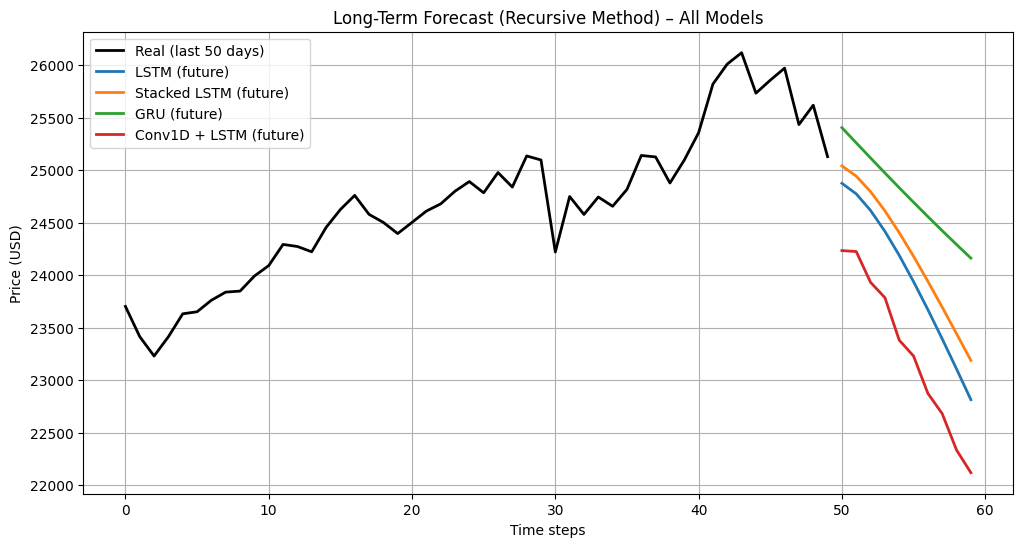

In [14]:
future_steps = 10  # predict next 10 days
window_size = X_test_NASDAQ.shape[1]       # normally 60
last_window = X_test_NASDAQ[-1]            # starting window

future_predictions_all = {}    # real-scale predictions for each model

# ---- Run long-term forecast for each model ----
for name, model in models.items():
    current_input = last_window.copy()
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(current_input.reshape(1, window_size, 1), verbose=0)
        future_predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(window_size, 1)

    # Convert predictions to original price scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_real = scaler.inverse_transform(future_predictions)

    future_predictions_all[name] = future_real


# ---- Combined plot ----
plt.figure(figsize=(12, 6))

# Plot last 50 real values
real_last_50 = scaler.inverse_transform(y_test_NASDAQ[-50:].reshape(-1, 1))
plt.plot(real_last_50, label="Real (last 50 days)", linewidth=2, color="black")

# Plot all model predictions
for name, future_real in future_predictions_all.items():
    plt.plot(
        np.arange(50, 50 + future_steps),
        future_real,
        label=f"{name} (future)",
        linewidth=2
    )

plt.title("Long-Term Forecast (Recursive Method) – All Models")
plt.xlabel("Time steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Exercice 2 : Génération de texte car2car L’objectif  de  cet  exercice  est  de  créer  un  programme  permettant  de  générer
automatiquement  la fin d’une phrase. Pour cela,  nous allons l’entrainer à prédire caractère
par  caractère  (car2car)  un  livre fourni.  Dans  cet  exercice,  nous  utiliserons  une  architecture
basée sur les LSTM. Le réseau sera entrainé sur un livre, Alice au pays de merveille, que vous
pouvez télécharger sur l’espace de cours.

1. Télécharger le fichier alice.txt depuis l’espace de cours. Charger ce fichier en python
et afficher son contenu.

In [15]:
with open("alice.txt", "r") as file:
    alice_text = file.read()
print(alice_text[:100])

﻿The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll

This eBook is fo


2. Depuis la chaîne de caractères précédemment chargée, générer la liste de caractères
uniques présents dans le livre. Écrire une méthode permettant de transformer chaque
caratère en entier et inversement (chaque entier en caractère). Ceci est nécessaire car
les réseaux de neurones ne travaillent pas sur des caractères mais sur des nombres !


In [16]:
chars = sorted(list(set(alice_text)))
print("Unique characters:", len(chars))
vocab_size = len(chars)

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

Unique characters: 90


3. Préparer  un  dataset  contenant  des  séquences  de  50  caractères  (paramétrable)  de
longueur en entrée et le caractère suivant cette séquence en target.

In [19]:
def prepare_car2car(text, window=50):
    encoded = [char_to_int[c] for c in text]

    X = []
    y = []

    for i in range(len(encoded) - window):
        X.append(encoded[i : i + window])
        y.append(encoded[i + window])

    return np.array(X), np.array(y)

X, y = prepare_car2car(alice_text)

X_train_alice, y_train_alice = X[:-n_test], y


X, y = prepare_data(NASDAQ100["Close/Last"])

n_test = int(len(X)*.2)
X_train_alice, X_test_alice = X[:-n_test], X[-n_test:]
y_train_alice, y_test_alice = y[:-n_test], y[-n_test:]

4. Transformer le dataset en séquence « one hot encodées »

In [21]:
from tensorflow.keras.utils import to_categorical

X_train_alice = to_categorical(X_train_alice, num_classes=vocab_size)
y_train_alice = to_categorical(y_train_alice, num_classes=vocab_size)

X_test_alice = to_categorical(X_test_alice, num_classes=vocab_size)
y_test_alice = to_categorical(y_test_alice, num_classes=vocab_size)

5. Proposer et tester différentes architecture LSTM entrainées sur le dataset
précédemment généré.

6. Tester la meilleure architecture sur une chaine de caractères qu’il n’a jamais vu, soit
du  dataset  de  test,  soit  que  vous  proposerez  vous.  Attention  à  bien  utiliser  votre
convertisseur caractère/entier pour pouvoir chiffrer et déchiffrer les informations du
réseau.